# Results wPCC VCT

In [1]:
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True
#%load_ext kedro.ipython

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.prime_system import PrimeSystem
from phd.visualization.plot_prediction import plot_total_force, plot_force_components, predict, plot_compare_model_forces, plot_parameter_contributions, group_parameters, joined_parameter_contributions, same_ylims
from vessel_manoeuvring_models.symbols import *
import matplotlib.pyplot as plt
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, remove_functions, prime
from vessel_manoeuvring_models.parameters import df_parameters
p = df_parameters["symbol"]
import sympy as sp
from sympy import Eq, symbols, latex
from phd.pipelines.load_wPCC.nodes import preprocess,zigzag_angle
from phd.pipelines.resimulate_with_autopilot.nodes import simulate_closed_loop, postprocess
from phd.visualization.plot_vct import plot_VCT, flat_keys, plot_VCT_components

import paper
from phd.visualization.styles import styles
from phd.visualization.units import units
from phd.visualization.symbols import symbols
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
from phd.pipelines.regression_VCT.nodes import subtract_centripetal_and_Coriolis
import matplotlib.ticker as plticker
from sklearn.metrics import mean_squared_error, r2_score
from phd.pipelines.regression_VCT.nodes import mirror, add_mirrored
import matplotlib.patches as mpatches 
from phd.visualization.circle_drift import plot_3d_circle_drift, predict_circle_drift_matrix, plot_3d_circle_drift_matplotlib
from phd.visualization.plot_vct import plot_group

In [3]:
ship_name = "wPCC"

In [4]:
#%reload_kedro
loaders = {f"polynomial rudder {name}":loader for name,loader in catalog.load(f"{ship_name}.models_VCT_polynomial_rudder").items()}
loaders["semiempirical rudder"] = catalog.load(f"{ship_name}.models_VCT")['semiempirical_covered_inertia']
loaders.pop('polynomial rudder complex')  # for now...

[04/10/25 08:45:10] WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/pa ]8;id=327683;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=895411;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             rtitioned_dataset.py:200: KedroDeprecationWarning:                                    
                             'PartitionedDataset' has been moved to `kedro-datasets` and will be                   
                             removed in Kedro 0.19.0.                                                              
                               warnings.warn(                                                                      
                                                                                                                   

                    WARNING  /home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/__ ]8;id=378663;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=501468;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             init__.py:44: KedroDeprecationWarning: 'AbstractDataSet' has been                     
                             renamed to 'AbstractDataset', and the alias will be removed in Kedro                  
                             0.19.0                                                                                
                               return getattr(kedro.io.core, name)                                                 
                                                                                                                   

                    INFO     Loading data from 'wPCC.models_VCT_polynomial_rudder'              ]8;id=82181;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=435353;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'wPCC.models_VCT' (PartitionedDataset)...        ]8;id=386816;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=694902;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

<bound method AbstractDataset.load of <phd.extras.datasets.model_dataset.ModularVesselSimulatorDataSet object at 0x7fa5b84e5660>>

In [5]:
models = {name:loader() for name,loader in loaders.items()}
model = models["semiempirical rudder"]

In [6]:
#model = models['polynomial rudder simple']

In [7]:
#df_VCT = catalog.load(f"{ship_name}.df_VCT_all_raw")['M5139-02-A_MS.df_VCT']()
#(df_VCT['fx'] - df_VCT['fx_rudders'] - df_VCT['fx_hull'] - model.parameters['Xthrustport']*df_VCT['thrust'])

In [8]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")

[04/10/25 08:45:15] INFO     Loading data from 'wPCC.df_VCT_scaled' (CSVDataSet)...             ]8;id=498424;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=652877;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [9]:
assert ((df_VCT['Y_D'] - df_VCT['Y_R'] - df_VCT['Y_H']).abs() < 10**-10).all()
assert ((df_VCT['N_D'] - df_VCT['N_R'] - df_VCT['N_H']).abs() < 10**-10).all()
assert ((df_VCT['X_D'] - df_VCT['X_R'] - df_VCT['X_P'] - df_VCT['X_H']).abs() < 10**-10).all()

In [10]:
df_VCT = catalog.load(f"{ship_name}.df_VCT_scaled")
mask = df_VCT['V'] > 0.9
df_VCT = df_VCT.loc[mask].copy()
df_VCT = add_mirrored(df_VCT)
df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])

#df_VCT = model.prime(data=df_VCT)
mask = df_VCT['test type'] == 'Rudder angle resistance (no propeller)'
df_VCT = df_VCT.loc[~mask].copy()


df_VCT['beta_deg'] = np.rad2deg(df_VCT['beta'])

df_VCT = subtract_centripetal_and_Coriolis(df_VCT=df_VCT, model=model)

                    INFO     Loading data from 'wPCC.df_VCT_scaled' (CSVDataSet)...             ]8;id=579173;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=368597;file:///home/maa/miniconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [11]:
df_prediction = predict(model=model, data=df_VCT)
df_prediction['Y_H']+=df_prediction['Y_RHI']
df_prediction['N_H']+=df_prediction['N_RHI']



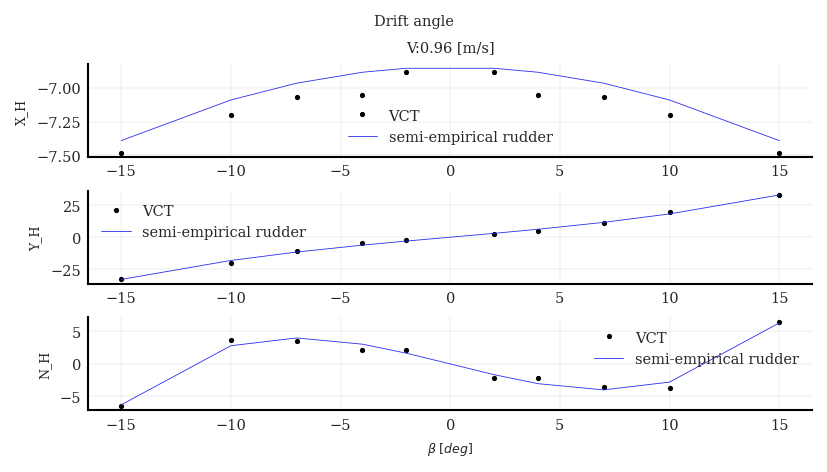

In [12]:
predictions = {
    "semiempirical rudder" : df_prediction,
}

plot_VCT(df_VCT=df_VCT, predictions=predictions, y_keys = ['X_H', 'Y_H', 'N_H'], test_type='Drift angle', styles=styles);

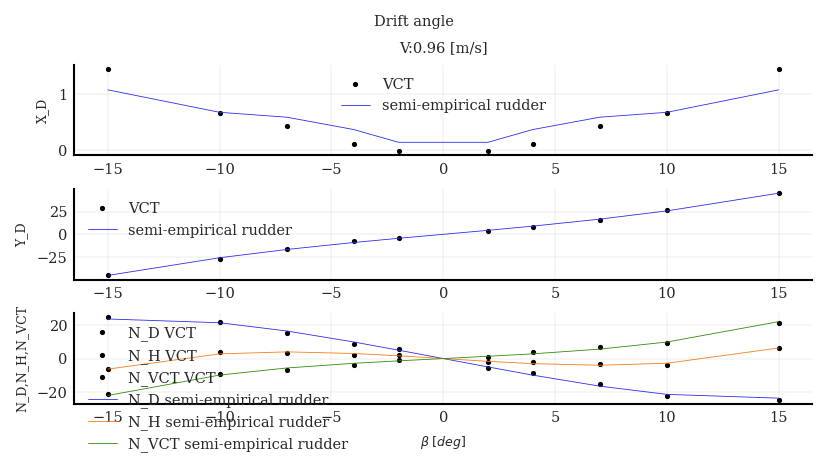

In [13]:
plot_VCT(df_VCT=df_VCT, predictions=predictions, y_keys=['X_D', 'Y_D', ['N_D','N_H','N_VCT']], test_type='Drift angle', styles=styles);

In [14]:
#df_VCT['X_P'] = df_VCT['thrust']

In [15]:
#df_prediction['X_H']+=df_prediction['thrust']*(1-model.parameters['Xthrustport'])

In [16]:
#df_prediction['X_D']+=df_prediction['thrust']*(1-model.parameters['Xthrustport'])

In [17]:
model.subsystems['hull'].equations['X_H']

Eq(X_H, X_{0} + X_{rr}*r**2 + X_{u}*u + X_{vr}*r*v + X_{vv}*v**2)

In [18]:
color_palette = ['k','c','r','m']
colors={}
for dof in ['X','Y','N']:
    color_all = color_palette.copy()
    for subscript in ['D','H','R','P']:
        key = f"{dof}_{subscript}"
        colors[key] = color_all.pop(0)
        

In [19]:
df_VCT['test type'].unique()


array(['Circle', 'Circle + Drift', 'Circle + Drift + rudder angle',
       'Circle + rudder angle', 'Drift angle', 'Rudder and drift angle',
       'Rudder angle', 'Thrust variation', 'self propulsion'],
      dtype=object)

[04/10/25 09:22:51] WARNING  /tmp/ipykernel_555680/2963269190.py:41: MatplotlibDeprecationWarning:  ]8;id=429286;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=487966;file:///home/maa/miniconda3/envs/phd/lib/python3.10/warnings.py#109\109]8;;\
                             An artist whose label starts with an underscore was passed to                         
                             legend(); such artists will no longer be ignored in the future.  To                   
                             suppress this warning, explicitly filter out such artists, e.g. with                  
                             `[art for art in artists if not art.get_label().startswith('_')]`.                    
                               fig.axes[0].legend(handles=patches, loc='upper center',                             
                             bbox_to_anchor=(0.5, 1.62), ncol=3)                                                   
                                                                                                                   

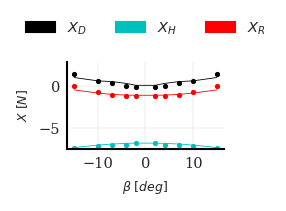

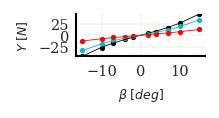

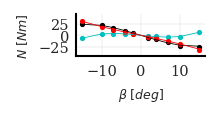

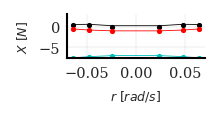

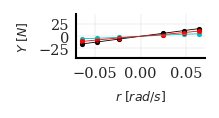

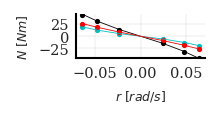

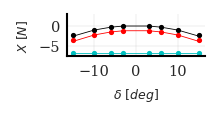

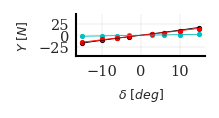

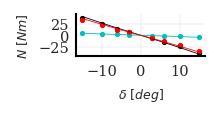

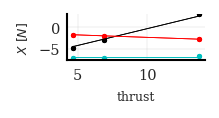

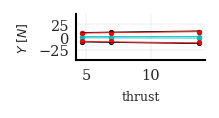

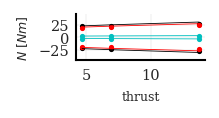

In [25]:
dofs={
    'X':{
        'y_label':r'$X$ $[N]$',
        'y_keys':['X_D','X_H','X_R'],
    },
    'Y':{
        'y_label':r'$Y$ $[N]$',
        'y_keys':['Y_D','Y_H','Y_R'],
    },
    'N':{
        'y_label':r'$N$ $[Nm]$',
        'y_keys':['N_D','N_H','N_R'],
    },
    
}

test_types = [
    'Drift angle',
    'Circle',
    'Rudder angle',
    'Thrust variation',
             ]

mask = df_prediction['test type'].isin(test_types)
df_prediction_test_types = df_prediction.loc[mask]
mask = df_VCT['test type'].isin(test_types)
df_VCT_test_types = df_VCT.loc[mask]

first = True
for test_type in test_types:
    for dof, meta_data in dofs.items():

        
        fig = plot_VCT_components(df_VCT=df_VCT, df_prediction=df_prediction, y_keys=[meta_data['y_keys'],], test_type=test_type, 
                            colors=colors);

        if first:
            labels = [line.get_label() for line in fig.axes[0].lines]
            colors_ = [line.get_color() for line in fig.axes[0].lines]
            patches = [mpatches.Patch(color=colors_[i], label=label) for i,label in enumerate(labels)]
            fig.axes[0].legend(handles=patches, loc='upper center', bbox_to_anchor=(0.5, 1.62), ncol=3)
            first = False
            #fig.tight_layout()
        else:
            fig.axes[0].get_legend().set_visible(False)


        ylim = [min([df_prediction_test_types[meta_data['y_keys']].min().min(), df_VCT_test_types[meta_data['y_keys']].min().min()]),
                max([df_prediction_test_types[meta_data['y_keys']].max().max(), df_VCT_test_types[meta_data['y_keys']].max().max()]),]
        fig.axes[0].set_ylim(ylim)
        
        fig.axes[0].set_ylabel(meta_data['y_label'])
        fig.set_size_inches(paper.figure_width/4, paper.figure_height/4)
        fig.suptitle('')
        fig.axes[0].set_title('')
        test_name = test_type.lower().replace(' ','_')
        file_name = f"{test_name}_{dof}"
        paper.save_fig(fig,f"{file_name}.svg")

In [65]:
paper.figure_width/4

1.3493725

In [66]:
#mask = ((df_VCT['delta'] == 0))
#df = df_VCT.loc[mask]
df = df_VCT.groupby('test type').get_group('Circle + Drift')
df = df.groupby('r').filter(lambda x:len(x) > 1)

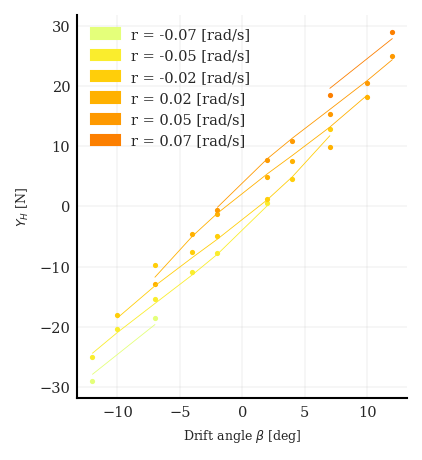

In [67]:
fig = plot_VCT(df_VCT=df, predictions=predictions, y_keys=['Y_H',], test_type='Circle + Drift', styles=styles);

labels = [f"r = {r_:0.2f} [rad/s]" for r_ in sorted(df['r'].unique())]
colors = [line.get_color() for line in fig.axes[0].lines]
patches = [mpatches.Patch(color=colors[i], label=label) for i,label in enumerate(labels)]

fig.axes[0].legend(labels, handles=patches)
fig.axes[0].set_xlabel(r'Drift angle $\beta$ [deg]')
fig.axes[0].set_ylabel(r'$Y_H$ [N]')
fig.axes[0].set_title('')
fig.suptitle('')
fig.set_size_inches(paper.figure_width/2,paper.figure_height)
paper.save_fig(fig,"circle_drift_Y_H.svg")

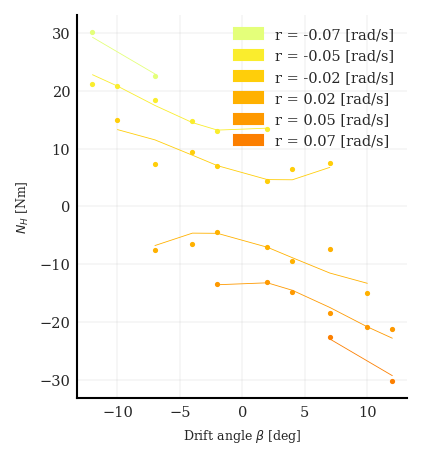

In [68]:

fig = plot_VCT(df_VCT=df, predictions=predictions, y_keys=['N_H',], test_type='Circle + Drift', styles=styles);

labels = [f"r = {r_:0.2f} [rad/s]" for r_ in sorted(df['r'].unique())]
colors = [line.get_color() for line in fig.axes[0].lines]
patches = [mpatches.Patch(color=colors[i], label=label) for i,label in enumerate(labels)]
fig.axes[0].legend(labels, handles=patches)

fig.axes[0].set_xlabel(r'Drift angle $\beta$ [deg]')
fig.axes[0].set_ylabel(r'$N_H$ [Nm]')
fig.axes[0].set_title('')
fig.suptitle('')
fig.set_size_inches(paper.figure_width/2,paper.figure_height)
paper.save_fig(fig,"circle_drift_N_H.svg")

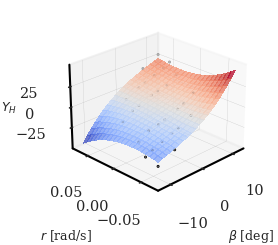

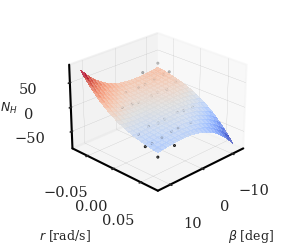

In [69]:
azim=225
fig = plot_3d_circle_drift_matplotlib(df=df, model=model, key='Y_H', azim=azim);
fig.set_size_inches(paper.figure_width/2,paper.figure_height/2)
paper.save_fig(fig,'Y_H.svg')

fig = plot_3d_circle_drift_matplotlib(df=df, model=model, key='N_H', azim=45);
fig.set_size_inches(paper.figure_width/2,paper.figure_height/2)
paper.save_fig(fig,'N_H.svg')


In [70]:
model2 = model.copy()

In [71]:
model2.parameters['Yvrr'] = 0
model2.parameters['Yvvr'] = 0
model2.parameters['Nvvr'] = 0
model2.parameters['Nvrr'] = 0

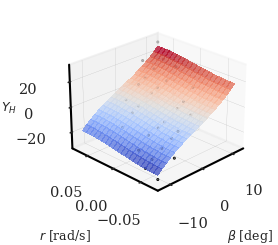

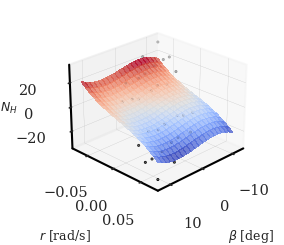

In [72]:
azim=225
fig = plot_3d_circle_drift_matplotlib(df=df, model=model2, key='Y_H', azim=azim);
fig.set_size_inches(paper.figure_width/3,paper.figure_height/2)
paper.save_fig(fig,'Y_H_no_coupling.svg')

fig = plot_3d_circle_drift_matplotlib(df=df, model=model2, key='N_H', azim=45);
fig.set_size_inches(paper.figure_width/3,paper.figure_height/2)
paper.save_fig(fig,'N_H_no_coupling.svg')

## $\kappa_v,\kappa_{v \gamma g}$ ?

In [73]:
df_prediction['test type'].unique()


array(['Circle', 'Circle + Drift', 'Circle + Drift + rudder angle',
       'Circle + rudder angle', 'Drift angle', 'Rudder and drift angle',
       'Rudder angle', 'Thrust variation', 'self propulsion'],
      dtype=object)

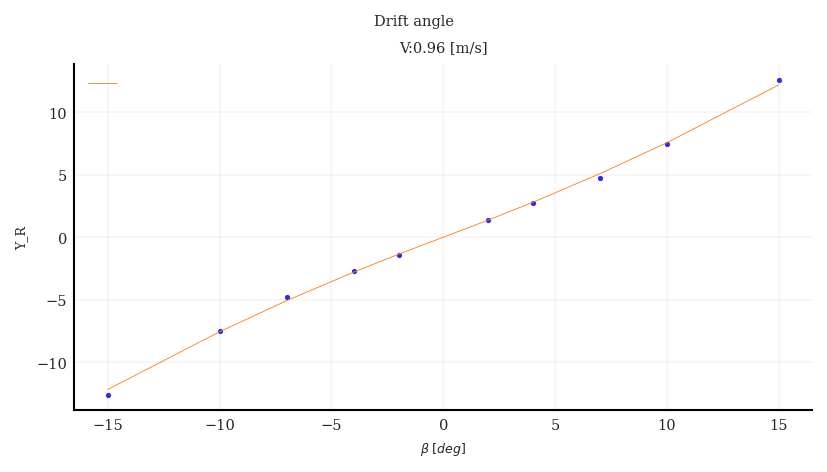

In [74]:
plot_VCT_components(df_VCT=df_VCT, df_prediction=df_prediction, test_type='Drift angle', y_keys=['Y_R']);

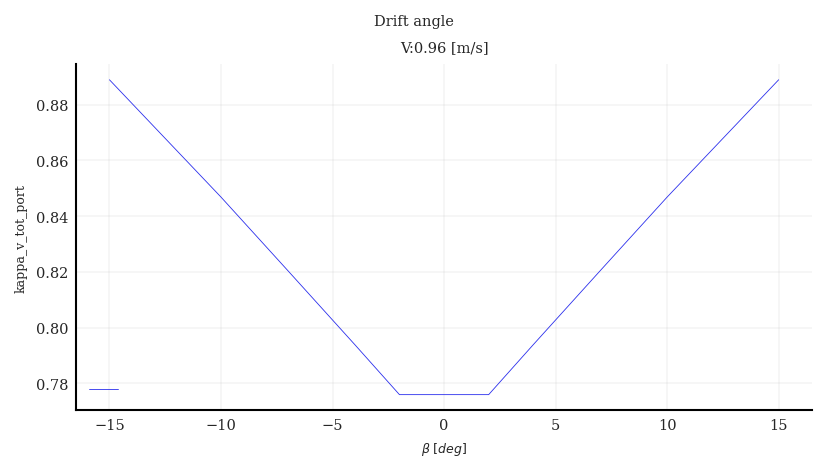

In [75]:
plot_VCT_components(df_VCT=df_VCT, df_prediction=df_prediction, test_type='Drift angle', y_keys=['kappa_v_tot_port']);

In [76]:
df_prediction['V_R_y_port']


2    -0.191172
3    -0.140493
4    -0.068094
6    -0.421123
7    -0.330203
8    -0.339562
9    -0.252729
10   -0.171864
11   -0.111109
12   -0.040936
13   -0.015050
14    0.024403
15   -0.304454
16   -0.171349
17   -0.203051
18   -0.220818
19   -0.096476
20   -0.126025
21   -0.096466
22   -0.096481
23   -0.126043
24   -0.172277
25   -0.172377
26   -0.140473
27   -0.068089
28   -0.068096
29   -0.068091
30    0.096162
31    0.141431
32    0.221281
33    0.026044
35    0.053261
36    0.026044
37    0.053255
38    0.053260
39    0.053262
40    0.000000
41    0.000000
42    0.000000
43    0.000000
44    0.000000
45    0.000000
46    0.000000
54   -0.202020
55   -0.173304
56   -0.321345
57   -0.147680
58   -0.100350
59   -0.173768
60   -0.083009
64    0.000000
2     0.191172
3     0.140493
4     0.068094
6     0.421123
7     0.330203
8     0.339562
9     0.252729
10    0.171864
11    0.111109
12    0.040936
13    0.015050
14   -0.024403
15    0.304454
16    0.171349
17    0.203051
18    0.2